## Balanced Extraction and Gap Filling on SWOT Data

**Balanced Extraction on SWOT data**
This notebook extracts the balanced component of SWOT data and fills gaps using a Gaussian Process. The notebook loads and processes the SWOT KaRIn and Nadir data and performs the balanced extraction. Physical and Spectral space plots are included. 

The notebook uses JWS_SWOT_toolbox which requires a Julia install with packages: ```FFTW, Interpolations, LinearAlgebra, Printf, ProgressMeter```. 

In [2]:
import JWS_SWOT_toolbox as swot
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from JWS_SWOT_toolbox.julia_bridge import julia_functions as jl

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206


In [4]:
# Config. 
# -------------------------
data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/' 

pass_number = 9
lat_min = 28 #32 #29
lat_max = 35 #38 #35
index = 6 # Time index to perform the extraction on

# return the files in the data directory for the specified pass number
# karin_files, nadir_files are sorted by cycle and contain the same cycles
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_number)

# Returns indexes for the Karin and Nadir data between lat_min and lat_max 
sample_index = 2 # some file we use to build the arrays in case the first one hsa NaNs
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims = [len(shared_cycles), track_length, track_length_nadir]

In [5]:
# Init the data classes
# -------------------------
karin, nadir = swot.init_swot_arrays(dims, lat_min, lat_max, pass_number)

# Load and process Karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# Load and process Nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Builds the coordinate grids -- in [m]
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

KaRIn Cycle 496 dropped: >20% bad-quality points
KaRIn Cycle 497 dropped: >20% bad-quality points


/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/import_and_process.py:230: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017327167681867872
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...



---- KaRIn spectrum parameters ----
Amp. balanced   :   2.6756e+04 ± 2.39e+02
lambda balanced :   2.2340e+02 ± 1.39e+00
slope balanced  :   4.7161e+00 ± 5.09e-02
Amp. noise      :   4.3583e+01 ± 3.48e+01
lambda noise    :   1.0001e+02 ± 4.83e+01
slope noise     :   1.7609e+00 ± 2.28e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 326.15501142043803 ± 1.46e+01



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

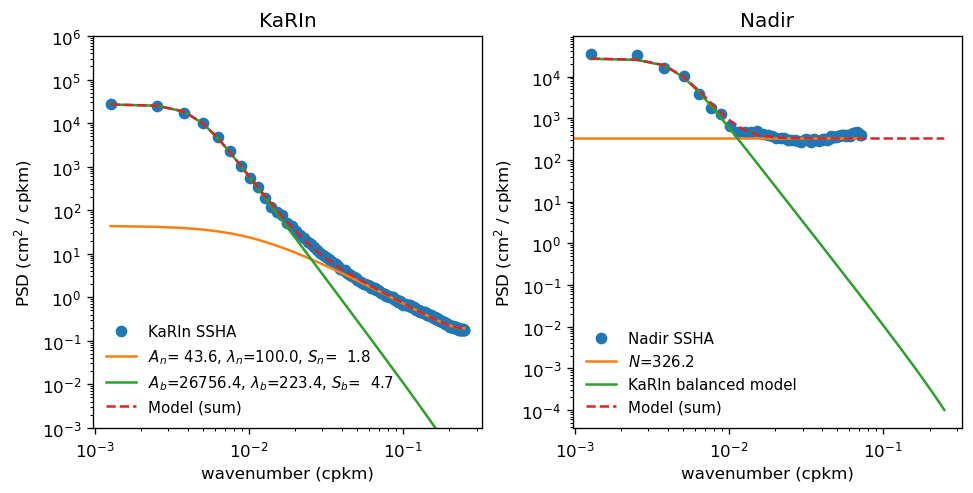

In [6]:
# Spectral Model Fits
# -------------------------
# KaRIn model fit
p_karin, _ = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
p_nadir, _ = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, p_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, p_karin, p_nadir)

In [7]:
# Geometry & masks
# -------------------------
mask_k = np.isfinite(karin.ssha[index])
mask_n = np.isfinite(nadir.ssh[index]).ravel()
    
xkk = (karin.x_grid[mask_k].ravel(order="C")) * 1e-3  # km
ykk = (karin.y_grid[mask_k].ravel(order="C")) * 1e-3
xnn = (nadir.x_grid.ravel()[mask_n]) * 1e-3
ynn = (nadir.y_grid.ravel()[mask_n]) * 1e-3

# Target grid (km)
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin, unit="km", extend=False)
n_t = xt.size

# Distance matrices in km
# -------------------------
def pairwise_r(x0, y0, x1=None, y1=None):
    # Euclidean distances between (x0,y0) and (x1,y1)
    if x1 is None:  # square
        dx = x0[:, None] - x0[None, :]
        dy = y0[:, None] - y0[None, :]
    else:
        dx = x0[:, None] - x1[None, :]
        dy = y0[:, None] - y1[None, :]
    return np.hypot(dx, dy)

r_kk = pairwise_r(xkk, ykk)
r_nn = pairwise_r(xnn, ynn) 
r_kn = pairwise_r(xkk, ykk, xnn, ynn)
r_tk = pairwise_r(xt, yt, xkk, ykk)
r_tn = pairwise_r(xt, yt, xnn, ynn) 
r_tt = pairwise_r(xt, yt)
print("Distance matrices built")

Distance matrices built


In [10]:
# Build covariance functions with spectral taper G and T
# -------------------------
RHO_L_KM = 0 # amount of Gaussian smoothing

B_psd = swot.balanced_psd_from_params(p_karin)                 # B(k) balanced power spectrum model
Nk_psd = swot.karin_noise_psd_from_params(p_karin)             # N_K(k) noise power spectrum model
sigma_n = np.sqrt(p_nadir[0] / (2.0 * nadir.dy_km))  # cm

n_samples = 10000
l_sample = 5000
kk = np.arange(n_samples // 2 + 1) / l_sample                  # wavenumber grid for transforms

rho           = 2 * np.pi * RHO_L_KM                           # ρ for Gaussian smooth
delta         = (np.pi * karin.dx_km) / (2 * np.log(2))        # δ for taper

# Gaussian and taper
G  = lambda k: np.exp(-((rho**2) * (k**2)) / 2.0)              # Gassian smooth C[BG]
T  = lambda k: np.exp(-((delta**2) * (k**2)) / 2.0)            # Taper C[BT]
G2 = lambda k: np.exp(-(rho**2) * (k**2))                    
GT = lambda k: np.exp(-(((rho**2 + delta**2)* k**2) / 2.0) ) 
T2 = lambda k: np.exp(-(delta**2) * (k**2))                    

C_B      = jl.cov(B_psd(kk), kk)                                         # C[B]
C_BT     = jl.cov(jl.abel(jl.iabel(B_psd(kk), kk) * T(kk), kk), kk)      # C[BT]
C_BG     = jl.cov(jl.abel(jl.iabel(B_psd(kk), kk) * G(kk), kk), kk)      # C[BT]
C_BG2    = jl.cov(jl.abel(jl.iabel(B_psd(kk),  kk) * G2(kk), kk), kk)    # C[BG^2]
C_BTG    = jl.cov(jl.abel(jl.iabel(B_psd(kk),  kk) * GT(kk), kk), kk)    # C[BGT]
C_BT2    = jl.cov(jl.abel(jl.iabel(B_psd(kk) + Nk_psd(kk),  kk) * T2(kk), kk), kk)    # C[BT^2]

# -------------------------
# Blocks
# -------------------------
# Observation terms
R_KK = np.asarray(C_BT2(r_kk), dtype=np.float64) # KaRIn-KaRIn
R_NN = np.asarray(C_B(r_nn)) + (sigma_n**2) * np.eye(r_nn.shape[0], dtype=np.float64) # Nadir–Nadir: C[B] + σ_N^2 
R_KN = np.asarray(C_BT(r_kn), dtype=np.float64)  # KaRIn-Nadir
R_NK = R_KN.T              

# Target terms 
R_tt = np.asarray(C_BG2(r_tt), dtype=np.float64) # Target-Target
R_tK = np.asarray(C_BTG(r_tk), dtype=np.float64) # Target-KaRIn    
R_tN = np.asarray(C_BG(r_tn), dtype=np.float64)  # Target-Nadir    
     
# Assemble observation covariance
C_obs = np.block([[R_KK, R_KN],
                  [R_NK, R_NN]])
R = np.concatenate([R_tK, R_tN], axis=1)

Cosine Transform
Variance from spectrum:   129.110458
Variance from covariance: 129.110458
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Cosine Transform
Variance from spectrum:   129.054035
Variance from covariance: 129.054035
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Cosine Transform
Variance from spectrum:   129.090153
Variance from covariance: 129.090153
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Cosine Transform
Variance from spectrum:   129.090153
Variance from covariance: 129.090153
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Cosine Transform
Variance from spectrum:   129.054035
Variance from covariance: 129.054035
Inverse Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Forward Abel Transform


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Cosine Transform
Variance from spectrum:   129.737531
Variance from covariance: 129.737531


Compute the Choleksy Factorization

In [11]:
# Cholesky factor
# -------------------------
cho = la.cho_factor(C_obs, lower=True)

In [ ]:
# Extraction 
# -------------------------
h_k = karin.ssha[index][mask_k].ravel()*100     # in [cm]
h_n = nadir.ssha[index][mask_n]*100             # in [cm]
h_obs = np.concatenate([h_k, h_n])

z  = la.cho_solve(cho, h_obs)                   # (C_obs)^{-1} h
ht = R @ z                                 
ht_map = (ht / 100.0).reshape(nyt, nxt).T       # back to [m] 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import importlib
importlib.reload(swot)
from scipy.ndimage import gaussian_filter
from matplotlib import rcParams

rcParams['axes.unicode_minus'] = True

def fmt_minus(x, ndp=1):
    s = f"{x:.{ndp}f}"
    return s.replace("-", "−")

dx_km = float(karin.dy) * 1e-3
dy_km = float(karin.dx) * 1e-3
vmin, vmax = -0.20, 0.20

x_km = np.linspace(0, nyt * karin.dx * 1e-3, ht_map.shape[1])
y_km = np.linspace(0, nxt * karin.dy * 1e-3, ht_map.shape[0])

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True, gridspec_kw={"hspace": 0.4})

x_grid_k = karin.x_grid
y_grid_k = karin.y_grid

mask_k_2d = np.isfinite(karin.ssha[index])
mask_n_1d = np.isfinite(nadir.ssha[index])

x_k_valid = x_grid_k[mask_k_2d].flatten()
y_k_valid = y_grid_k[mask_k_2d].flatten()
ssh_k_valid = karin.ssha[index][mask_k_2d].flatten()

# Nadir assumed 1D
x_n_valid = nadir.x_grid[mask_n_1d]
y_n_valid = nadir.y_grid[mask_n_1d]
ssh_n_valid = nadir.ssha[index][mask_n_1d]

sc1 = axes[0].scatter(
    y_k_valid * 1e-3, x_k_valid * 1e-3,
    c=ssh_k_valid, s=5, cmap='cmo.balance',
    vmin=vmin, vmax=vmax, edgecolor="none",
    rasterized=True
)
axes[0].scatter(
    y_n_valid * 1e-3, x_n_valid * 1e-3,
    c=ssh_n_valid, s=5, cmap='cmo.balance',
    vmin=vmin, vmax=vmax, edgecolor="none",
    rasterized=True
)
axes[0].set_title("Observed SSHA")
axes[0].set_ylabel("across-track (km)")
axes[0].margins(x=0, y=0)
axes[0].set_ylim(0, y_km.max())
axes[0].set_xlim(0, x_km.max())
axes[0].set_aspect("equal")

cbar0 = fig.colorbar(sc1, ax=axes[0], shrink=0.7, pad=0.02)
cbar0.set_ticks([vmin, 0, vmax])
cbar0.set_ticklabels([fmt_minus(vmin), "0.0", fmt_minus(vmax)])
cbar0.set_label(r'SSHA [m]')

lats = np.linspace(
    np.nanmin(karin.lat[index, :, :]),
    np.nanmax(karin.lat[index, :, :]),
    ht_map.shape[0]
)
geo_vort = swot.compute_geostrophic_vorticity(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
_, _, geo_vel = swot.compute_geostrophic_velocity(np.ma.masked_invalid(ht_map), 2000, 2000, lats)

grad_vmin, grad_vmax = 0.0, 1.5
vort_vmin, vort_vmax = -1.0, 1.0

ht_plot = np.ma.masked_invalid(np.clip(ht_map, vmin, vmax))
geo_vel_plot = np.ma.masked_invalid(np.clip(geo_vel, grad_vmin, grad_vmax))
geo_vort_plot = np.ma.masked_invalid(np.clip(geo_vort, vort_vmin, vort_vmax))

extent = [0, x_km.max(), 0, y_km.max()]

im0 = axes[1].imshow(
    ht_plot, origin="lower", extent=extent,
    cmap='cmo.balance', vmin=vmin, vmax=vmax, rasterized=True
)
axes[1].set_title("Extracted Balanced SSHA")
axes[1].set_ylabel("across-track (km)")
axes[1].set_aspect("equal")

cbar1 = fig.colorbar(im0, ax=axes[1], shrink=0.7, pad=0.02)
cbar1.set_ticks([vmin, 0, vmax])
cbar1.set_ticklabels([fmt_minus(vmin), "0.0", fmt_minus(vmax)])
cbar1.set_label(r'SSHA [m]')

im1 = axes[2].imshow(
    geo_vel_plot, origin="lower", extent=extent,
    cmap='cmo.deep_r', vmin=grad_vmin, vmax=grad_vmax, rasterized=True
)
axes[2].set_title(r"Geostrophic Speed")
axes[2].set_ylabel("across-track (km)")
axes[2].set_aspect("equal")

cbar2 = fig.colorbar(im1, ax=axes[2], shrink=0.7, pad=0.02)
cbar2.set_ticks([grad_vmin, 0, grad_vmax])
cbar2.set_ticklabels([fmt_minus(grad_vmin), "0.0", fmt_minus(grad_vmax)])
cbar2.set_label(r'$|\mathbf{u}_g|$ [m s$^{-1}$]')

im2 = axes[3].imshow(
    geo_vort_plot, origin="lower", extent=extent,
    cmap='cmo.curl', vmin=vort_vmin, vmax=vort_vmax, rasterized=True
)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
axes[3].set_aspect("equal")

cbar3 = fig.colorbar(im2, ax=axes[3], shrink=0.7, pad=0.02)
cbar3.set_ticks([vort_vmin, 0, vort_vmax])
cbar3.set_ticklabels([fmt_minus(vort_vmin), "0.0", fmt_minus(vort_vmax)])
cbar3.set_label(r'$\zeta_g / f$')

panels = ["a)", "b)", "c)", "d)"]
for i, ax in enumerate(axes):
    ax.set_title(panels[i], loc='left', fontsize=13)

yticks = np.arange(0, y_km.max() + 1, 40)
for ax in axes:
    ax.set_yticks(yticks)

plt.savefig("balanced_extraction.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
# Compute the Posterior and Posterior Variance (cell takes a while)
# -------------------------
from scipy.linalg import solve_triangular
L, lower = la.cho_factor(C_obs, lower=True, check_finite=False, overwrite_a=False)
W = solve_triangular(L, R.T, lower=True, check_finite=False, overwrite_b=False)

C_mean = W.T @ W                                        # covariance of posterior mean R @ C_obs^{-1} @ R.T

P = R_tt - C_mean                                       # Posterior covariance

posterior_variance = np.diag(P)
posterior_variance_field = posterior_variance.reshape(nyt, nxt)

print("Cholesky")
L_P = np.linalg.cholesky(P)                             # Cholesky factor of posterior covariance

eps = 1e-10 * np.trace(C_mean) / C_mean.shape[0]        # Cholesky factor of posterior-mean covariance
L_mean = np.linalg.cholesky(C_mean + eps * np.eye(C_mean.shape[0]))

print("Done.")

Cholesky
Done.


In [ ]:
# perform diagnostics on the matrixes if needed
# swot.diagnose_not_positive_definite(C_mean)

=== Positive Definite Diagnostic ===

Symmetric: True

--- Eigenvalue Analysis ---


In [13]:
# Compute the spectra of the reconstruction, covariance, and posterior samples (Fig. 5)
# -------------------------
import xarray as xr
import xrft

def power_spec_1d(field):
    f2d = np.array(field).reshape((nyt, nxt), order="C")
    da = xr.DataArray(
        f2d[None, :, :],
        coords=[[0], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr = swot.mean_power_spectrum(da, karin.window, 'line', ['sample', 'pixel'])
    # Keep positive wavenumbers along-track
    half = int(karin.track_length // 2)
    spec_vals = 2 * spec_xr[half:]  # 2 times for one-sided spectrum
    if spec_vals.size != karin.wavenumbers_cpkm.size:
        spec_vals = spec_vals[:karin.wavenumbers_cpkm.size]
    return np.asarray(spec_vals)

# Posterior draws 
rng = np.random.default_rng(seed=42)
nreal = 20

all_specs            = []  # spectra of posterior samples (mean + ε)
all_specs_uncert     = []  # spectra of ε ~ N(0, P)
all_specs_mean_cov   = []  # spectra of η ~ N(0, C_mean)

for _ in range(nreal):
    # Uncertainty draw (ε) and sample = ht + ε
    z   = rng.standard_normal(P.shape[0])
    eps = L_P @ z
    sample = ht + eps

    all_specs.append(power_spec_1d(sample))
    all_specs_uncert.append(power_spec_1d(eps))

    # Posterior-mean covariance draw
    zm = rng.standard_normal(C_mean.shape[0])
    eta = L_mean @ zm
    all_specs_mean_cov.append(power_spec_1d(eta))

# Aggregate the spectra 
all_specs            = np.asarray(all_specs)
all_specs_uncert     = np.asarray(all_specs_uncert)
all_specs_mean_cov   = np.asarray(all_specs_mean_cov)

spec_mean              = np.nanmean(all_specs, axis=0)
spec_std               = np.nanstd(all_specs, axis=0)
spec_median            = np.nanmedian(all_specs, axis=0)
spec_mean_uncertainty  = np.nanmean(all_specs_uncert, axis=0)
spec_mean_of_mean      = np.nanmean(all_specs_mean_cov, axis=0)

print("Done")

Done


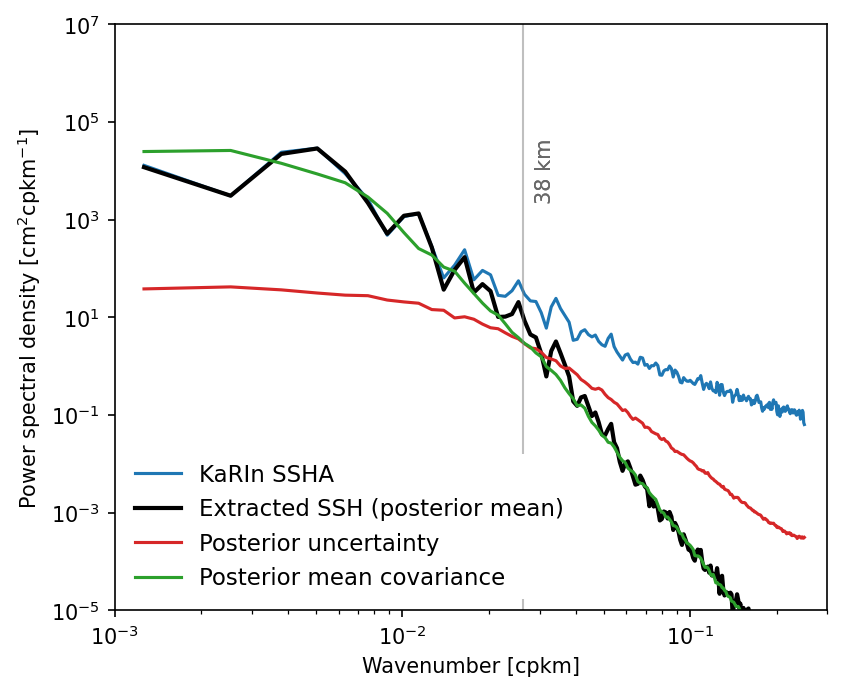

In [14]:
def plot_spectrum_comparison(karin_obj, swot_obj, ht_map_2d):
    k_karin = karin_obj.wavenumbers_cpkm[int(karin_obj.track_length/2):]
    karin_spec_sample_mean = karin_obj.spec_alongtrack_av[int(karin_obj.track_length/2):]
    k_karin_sliced = k_karin[1:]

    nx_dim = ht_map_2d.shape[1] # Along-track 
    ny_dim = ht_map_2d.shape[0] # Across-track  
    ht_map_coords = {
        'pixel': np.arange(0, ny_dim) * karin_obj.dy_km, # Across-track 
        'line': np.arange(0, nx_dim) * karin_obj.dx_km   # Along-track 
    }
    ht_map_xr = xr.DataArray((ht_map_2d - np.mean(ht_map_2d)), coords=ht_map_coords, dims=['pixel', 'line'])
    spec_ht_map_2s = swot_obj.mean_power_spectrum(ht_map_xr, karin_obj.window, 'line', ['pixel'])
    spec_ht_map = spec_ht_map_2s[int(karin_obj.track_length/2):][1:]
    spec_k_ins = karin.spec_alongtrack_ins[index][int(karin_obj.track_length/2):][1:]

    fig, axs = plt.subplots(1, 1, figsize=(5.5, 4.5), dpi=150, constrained_layout=True)
    k_km = k_karin_sliced 
    
    axs.loglog(k_km, spec_k_ins, color='tab:blue', label='KaRIn SSHA')
    axs.loglog(k_km, spec_ht_map , '-', lw=2, color='black',label='Extracted SSH (posterior mean)')
    axs.loglog(k_km[:], 0.5*spec_mean_uncertainty[1:], color='tab:red', label = 'Posterior uncertainty')
    axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:],color='tab:green', label = 'Posterior mean covariance')

    #axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:] + 0.5*spec_mean_uncertainty[1:],color='tab:purple', label = 'Sum')

    separation_scale_km = 38
    separation_wavenumber = 1/separation_scale_km 
    axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    text_label = f'{separation_scale_km:.0f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label, rotation=90,color='dimgrey',fontsize=10,verticalalignment='center',horizontalalignment='left')

    # separation_scale_km = 71
    # separation_wavenumber = 1/separation_scale_km 
    # axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    # text_label = f'{separation_scale_km:.0f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label,rotation=90, color='dimgrey', fontsize=10, verticalalignment='center', horizontalalignment='left')
    axs.set_xlabel('Wavenumber [cpkm]')
    axs.set_ylabel('Power spectral density [cm$^2$cpkm$^{-1}$]')
    axs.set_xlim(1e-3, 3e-1)
    axs.set_ylim(1e-5, 1e7)
    axs.legend(loc='lower left',frameon=True,facecolor='white',edgecolor='none',framealpha=1.0,fontsize=11)
    
    plt.savefig('balanced_spectrum.pdf', bbox_inches='tight')
    plt.show()

ht_map = ht.reshape(nyt, nxt).T 
plot_spectrum_comparison(karin_obj=karin,swot_obj=swot,ht_map_2d=ht_map)